# Activity 5

## Segmentation

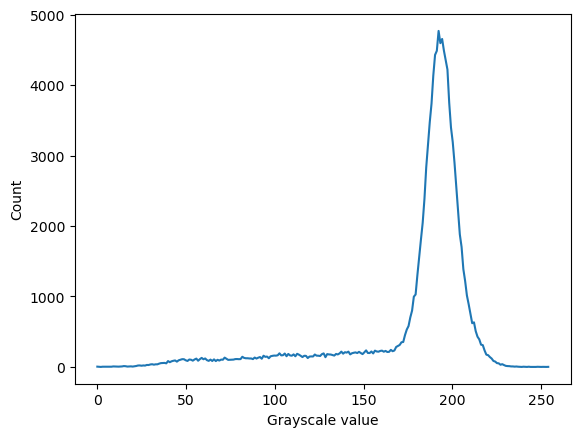

In [79]:
import numpy as np
import matplotlib.pyplot as plt

check = plt.imread('cropped_grayscale_check.jpg')

count, cells = np.histogram(check.flatten(),256)
plt.plot(cells[:-1],count)
plt.xlabel('Grayscale value')
plt.ylabel('Count')
# plt.savefig('check_hist.png')
plt.show()

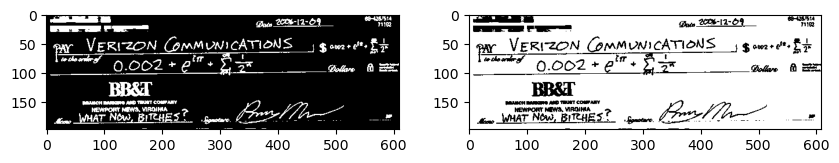

In [80]:
ROI_less = check < 150
ROI_greater = check > 150

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plt.imshow(ROI_less, cmap='gray')
ax = fig.add_subplot(122)
plt.imshow(ROI_greater, cmap='gray')

# plt.imsave('ROI_text.png', ROI_less, cmap='gray')
# plt.imsave('ROI_bg.png', ROI_greater, cmap='gray')

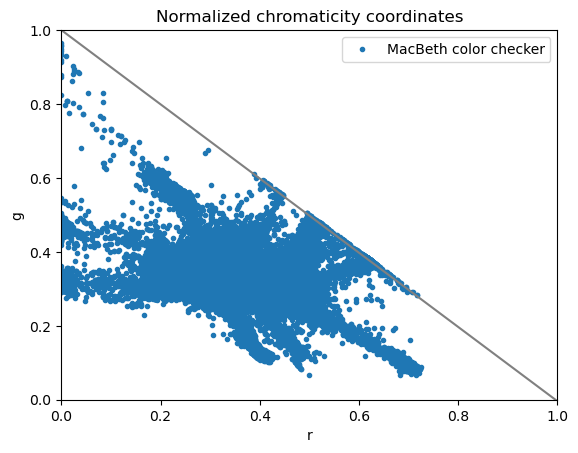

96 116 81 0.3276450511945393


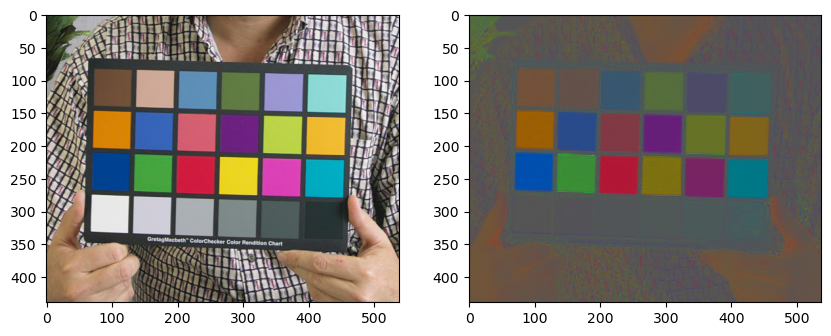

In [103]:
def img_norm(img):
    img = img/255
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    I = R+G+B
    I = np.where(I==0, 10e10, I)
    R_norm = R/I
    G_norm = G/I
    B_norm = B/I
    img_norm = np.dstack([R_norm,G_norm,B_norm])
    return img_norm

def NCC(img,desc):
    x = np.linspace(0,255,255)
    y = -x+1
    img_normed = img_norm(img)
    plt.plot(img_normed[:,:,0].flatten(),img_normed[:,:,1].flatten(), '.', label=desc)
    plt.plot(y, c='gray')
    plt.xlabel('r')
    plt.ylabel('g')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('Normalized chromaticity coordinates')
    plt.legend()
    plt.show()

    
color_checker = plt.imread('Gretag-Macbeth_ColorChecker.jpg')
color_checker_norm = img_norm(color_checker)

NCC(color_checker,'MacBeth color checker')

fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(121)
plt.imshow(color_checker)
ax = fig.add_subplot(122)
plt.imshow(color_checker_norm)
# plt.colorbar()
print(color_checker[0,2,0], color_checker[0,2,1], color_checker[0,2,2], color_checker_norm[0,2,0])

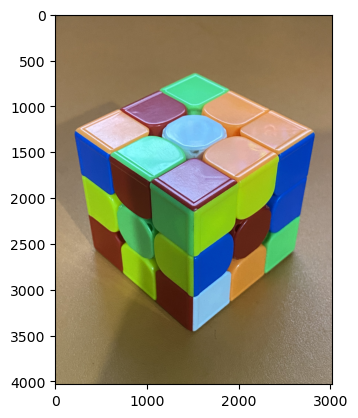

In [104]:
cube = plt.imread('cubecorner.png')
cube_norm = img_norm(cube)

plt.imshow(cube)

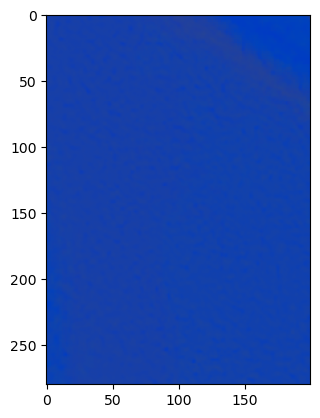

In [189]:
import cv2

cube_ROI = cube[1470:1750,300:500]
cube_ROI_norm = img_norm(cube_ROI)
plt.imshow(cube_ROI_norm)

# image_with_roi = cube.copy()
# image_with_roi = cv2.rectangle(image_with_roi, (1500,1750), (300,500), (0, 255, 0), 2)
# plt.imshow(image_with_roi)

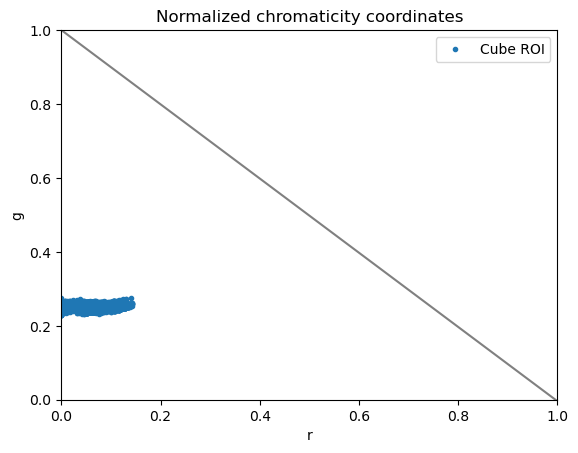

In [190]:
NCC(cube_ROI,'Cube ROI')

In [191]:
def gaussian_PDF(img, ROI):
    r = img[:,:,0]
    g = img[:,:,1]
    
    ROI_r = ROI[:,:,0]
    ROI_g = ROI[:,:,1]
    
    mu_r = np.mean(ROI_r)
    mu_g = np.mean(ROI_g)
    sigma_r = np.std(ROI_r)
    sigma_g = np.std(ROI_g)
    
    gauss_r = 1/(sigma_r*np.sqrt(2*np.pi))*np.exp(-(r-mu_r)**2/(2*sigma_r**2))
    gauss_g = 1/(sigma_g*np.sqrt(2*np.pi))*np.exp(-(g-mu_g)**2/(2*sigma_g**2))
    return gauss_r*gauss_g

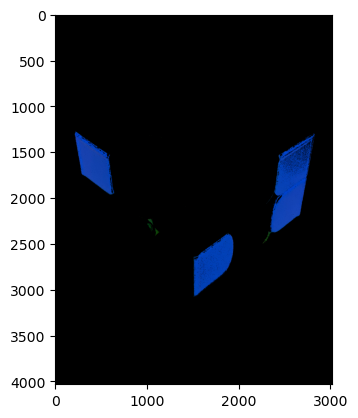

In [196]:
cube_gauss = gaussian_PDF(cube, cube_ROI)


cube_mask = cube_gauss >0.1
rcube = cube[:,:,0]*cube_mask
gcube = cube[:,:,1]*cube_mask
bcube = cube[:,:,2]*cube_mask
cube_masked = np.dstack((rcube,gcube,bcube))

plt.imshow(cube_masked)

In [198]:
def parametric(img, ROI):
    
    img_gauss = gaussian_PDF(img, ROI)


    img_mask = img_gauss >0.1
    r = img[:,:,0]*img_mask
    g = img[:,:,1]*img_mask
    b = img[:,:,2]*img_mask
    img_segmented = np.dstack((r,g,b))

    plt.imshow(img_segmented)

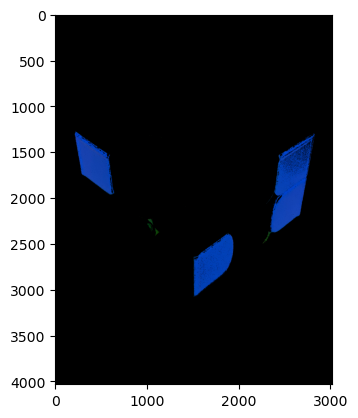

In [199]:
parametric(cube, cube_ROI)